# FICO Explainable ML: HELOC


## Introduction
In this walkthrough, we'll use Xplainable's platform to analyze the FICO Home Equity Line of Credit (HELOC) dataset. This dataset is commonly used to predict credit risk, helping to identify borrowers who may be at risk of defaulting on their line of credit.

We'll go step-by-step through Xplainable's features, starting with data preprocessing, moving on to model training, and finally, interpreting the results. The goal is to show how Xplainable can simplify the process of building and understanding machine learning models, providing clear insights without the need for complex coding or deep statistical knowledge. By the end of this walkthrough, you'll see how Xplainable can help you quickly draw meaningful conclusions from the FICO HELOC dataset.

# Install and import relevant packages

In [16]:
!pip install xplainable
!pip install altair==5.4.1 #Upgrade this to work in Google Colab
!pip install xplainable-client
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 162.6 kB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 494.4 kB/s eta 0:00:00a 0:00:01
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=abe59f290d0441fc580ee9cf74b91b1c6f25262d844d97acdf0e4604e2d1ad61
  Stored in directory: /Users/jtuppack/Library/Caches/pip/wheels/9f/af/22/bf406f913dc7506a485e60dce8143741abd0a92a19337d83a3
Successfully built kaggle


In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
import json
import requests

import xplainable_client
import xplainable as xp
from xplainable.core import XClassifier
from xplainable.core.optimisation.bayesian import XParamOptimiser

# 1. Import CSV and Perform Data Processing

In [18]:
import os
import pandas as pd

def load_heloc_data(
        use_kaggle=True, 
        kaggle_dataset_path="./data/heloc_dataset.csv", 
        local_path='./data/heloc_dataset.csv'):
    # Check if using Kaggle API
    if use_kaggle:
        try:
            # Import the Kaggle API
            from kaggle.api.kaggle_api_extended import KaggleApi

            # Initialize and authenticate the Kaggle API
            api = KaggleApi()
            api.authenticate()

            # Download the dataset
            print("Downloading dataset from Kaggle...")
            api.dataset_download_files(kaggle_dataset_path, path='./data', unzip=True)

            # Load the dataset
            data = pd.read_csv('./data/heloc_dataset.csv')
            print("Dataset loaded from Kaggle.")
            return data

        except Exception as e:
            print(f"Error downloading dataset from Kaggle: {e}. Falling back to local version.")

    # Load from the local path if Kaggle download fails or is not selected
    try:
        data = pd.read_csv(local_path)
        print("Dataset loaded from local path.")
        return data
    except FileNotFoundError:
        print("Local file not found. Please check the file path.")

# Usage
data = load_heloc_data(use_kaggle=True)  # Set to False to skip Kaggle and use the local file
data.head()


Error downloading dataset from Kaggle: Could not find kaggle.json. Make sure it's located in /Users/jtuppack/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/. Falling back to local version.
Dataset loaded from local path.


,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,Bad,55,144,4,84,20,3,0,83,2,...,43,0,0,0,33,-8,8,1,1,69
1,Bad,61,58,15,41,2,4,4,100,-7,...,67,0,0,0,0,-8,0,-8,-8,0
2,Bad,67,66,5,24,9,0,0,100,-7,...,44,0,4,4,53,66,4,2,1,86
3,Bad,66,169,1,73,28,1,1,93,76,...,57,0,5,4,72,83,6,4,3,91
4,Bad,81,333,27,132,12,0,0,100,-7,...,25,0,1,1,51,89,3,1,0,80


Where the defition of each of the fields are below:

| Variable Names                       | Description                                                                                             |
|--------------------------------------|---------------------------------------------------------------------------------------------------------|
| RiskPerformance                      | Paid as negotiated flag (12-36 Months). String of Good and Bad                                          |
| ExternalRiskEstimate                 | Consolidated version of risk markers                                                                    |
| MSinceOldestTradeOpen                | Months Since Oldest Trade Open                                                                          |
| MSinceMostRecentTradeOpen            | Months Since Most Recent Trade Open                                                                     |
| AverageMInFile                       | Average Months in File                                                                                  |
| NumSatisfactoryTrades                | Number of Satisfactory Trades                                                                           |
| NumTrades60Ever2DerogPubRec          | Number of Trades 60+ Ever                                                                               |
| NumTrades90Ever2DerogPubRec          | Number of Trades 90+ Ever                                                                               |
| PercentTradesNeverDelq               | Percent of Trades Never Delinquent                                                                      |
| MSinceMostRecentDelq                 | Months Since Most Recent Delinquency                                                                    |
| MaxDelq2PublicRecLast12M             | Max Delinquency/Public Records in the Last 12 Months. See tab 'MaxDelq' for each category               |
| MaxDelqEver                          | Max Delinquency Ever. See tab 'MaxDelq' for each category                                               |
| NumTotalTrades                       | Number of Total Trades (total number of credit accounts)                                                |
| NumTradesOpeninLast12M               | Number of Trades Open in Last 12 Months                                                                 |
| PercentInstallTrades                 | Percent of Installment Trades                                                                           |
| MSinceMostRecentInqexcl7days         | Months Since Most Recent Inquiry excluding the last 7 days                                              |
| NumInqLast6M                         | Number of Inquiries in the Last 6 Months                                                                |
| NumInqLast6Mexcl7days                | Number of Inquiries in the Last 6 Months excluding the last 7 days. Excluding the last 7 days removes inquiries that are likely due to price comparison shopping. |
| NetFractionRevolvingBurden           | This is the revolving balance divided by the credit limit                                               |
| NetFractionInstallBurden             | This is the installment balance divided by the original loan amount                                     |
| NumRevolvingTradesWBalance           | Number of Revolving Trades with Balance                                                                 |
| NumInstallTradesWBalance             | Number of Installment Trades with Balance                                                               |
| NumBank2NatlTradesWHighUtilization   | Number of Bank/National Trades with high utilization ratio                                              |
| PercentTradesWBalance                | Percent of Trades with Balance                                                                          |


### Seperate data into target (y) and features (x)


In [19]:
y = data['RiskPerformance']
x = data.drop('RiskPerformance',axis=1)

### Create test and train datasets


In [20]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42, stratify=y)

# 2. Model Optimisation

Xplainable's ```XParamOptimiser ```fine-tunes the hyperparameters of our model. This produces the most optimal parameters that will result in the best model performance.



In [21]:
y_train_df = pd.Series(y_train)

optimiser = XParamOptimiser(metric='f1-score',n_trials=300, n_folds=2, early_stopping=150)
params = optimiser.optimise(x_train, y_train_df)

 74%|███████▍  | 223/300 [00:14<00:04, 15.92trial/s, best loss: -0.7057194555537591]


## 3. Model Training

The `XClassifier` is trained on the dataset, with the optimised parameters.

In [22]:
model = XClassifier(**params)
model.fit(x_train, y_train)

# 4. Explaining and Interpreting the Model

Following training, the `model.explain()` method is called to generate insights into the model's decision-making process. This step is crucial for understanding the factors that influence the model's predictions and ensuring that the model's behaviour is transparent and explainable.

In [13]:
model.explain()

alt.HConcatChart(...)

## Analysing Feature Importances and Contributions
Click on the bars to see the importances and contributions of each variable.

### Feature Importances
The relative significance of each feature (or input variable) in making predictions. It indicates how much each feature contributes to the model’s predictions, with higher values implying greater influence.

## Feature Significance
The effect of each feature on individual predictions. For instance, in this model, feature contributions would show how each feature (like the net fraction of trades revolving burden) affects the predicted risk estimate for a particular applicant.

# 5. Saving a model to Xplainable's app

In this step, we first create a unique identifier for our HELOC risk prediction model using client.create_model_id. This identifier, referred to as model_id, represents the newly created model that predicts the likelihood of applicants defaulting on their line of credit. After creating this model identifier, we generate a specific version of the model using client.create_model_version, passing in our training data. The resulting version_id represents this particular iteration of our model, allowing us to track and manage different versions systematically.

Creat an API key in the Xplainable platform

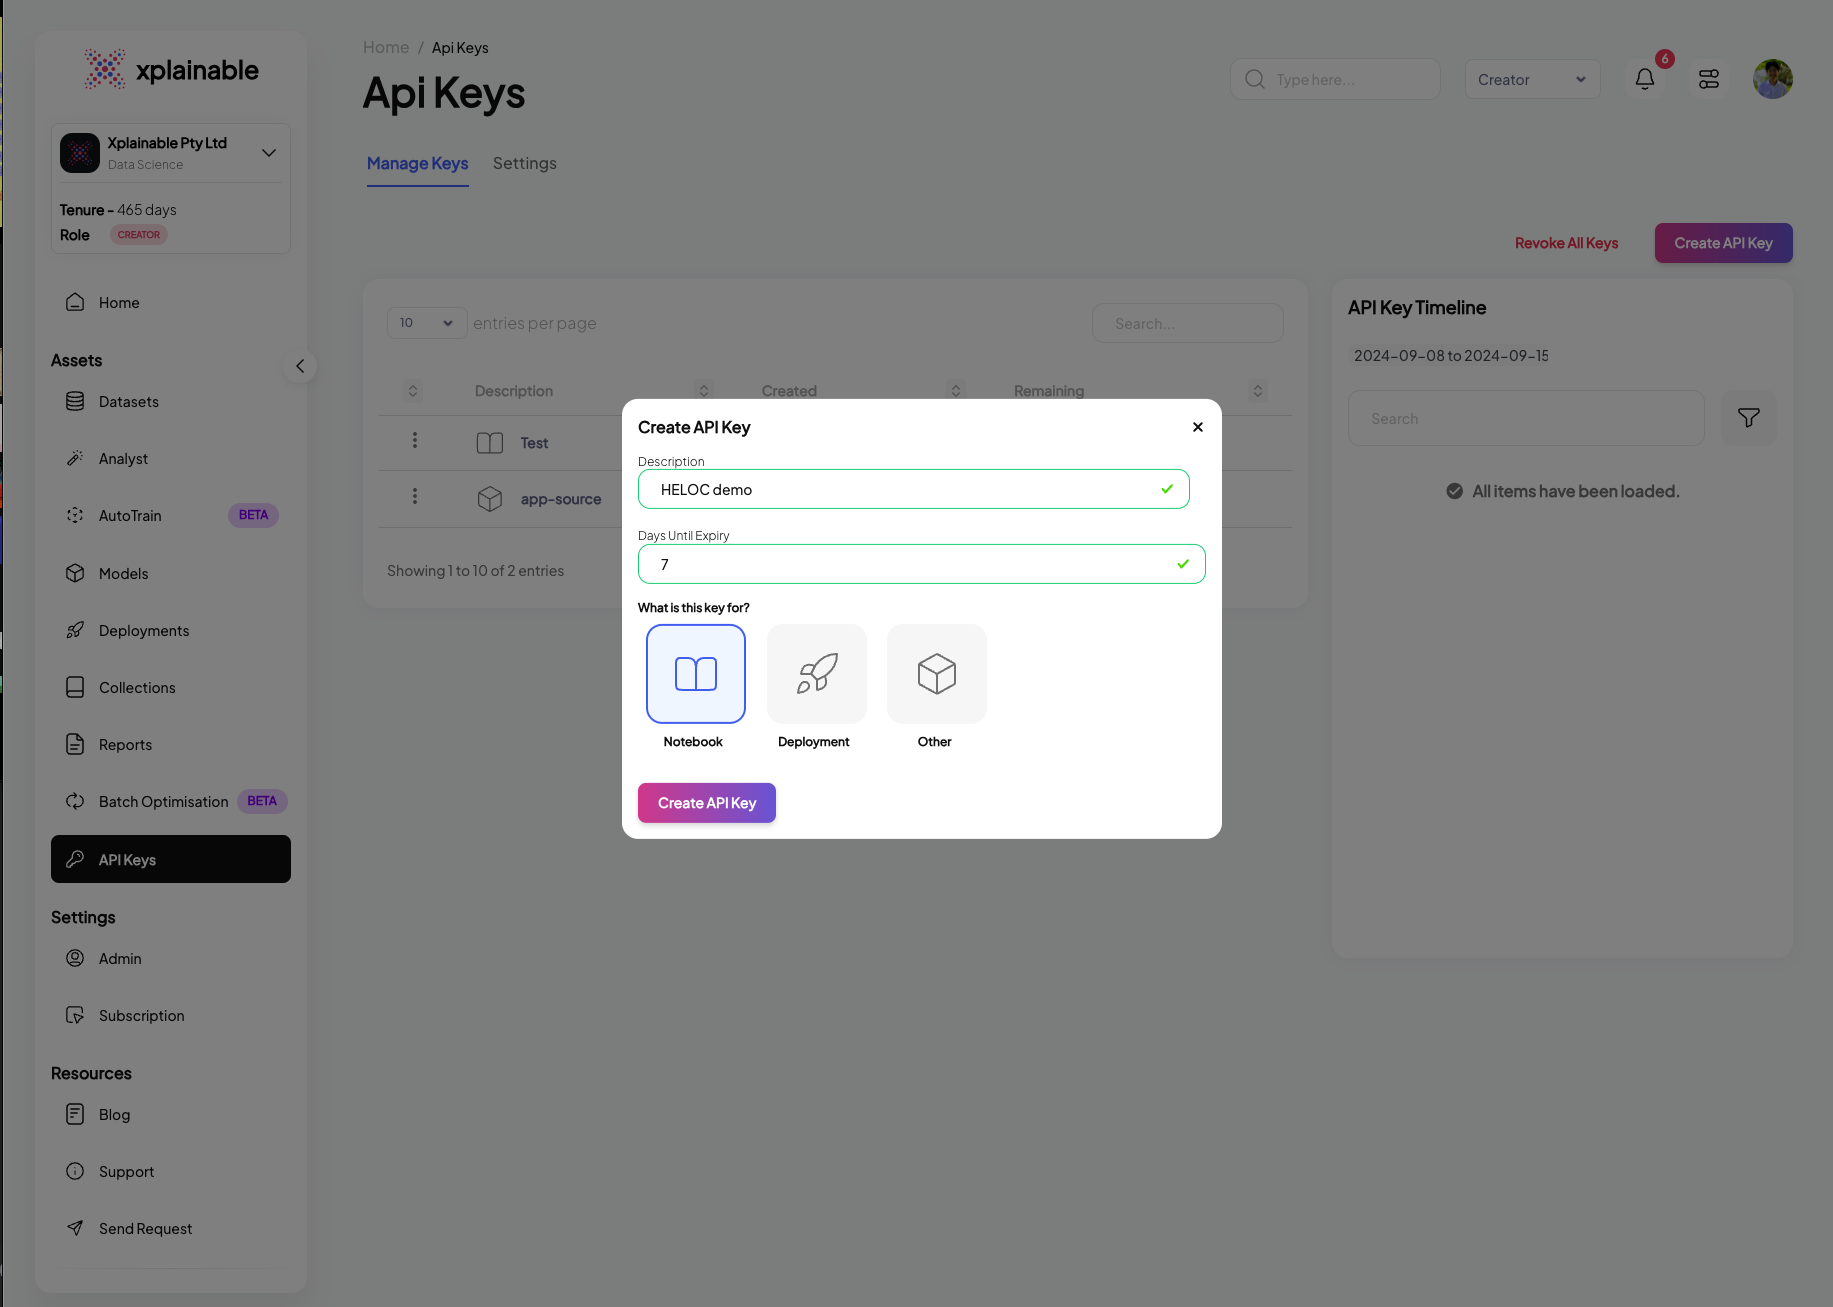

In [25]:
client = xplainable_client.Client(
    api_key="f6eaf63f-598e-4dfc-9ebd-a343386d1905",
    hostname="https://xplainable-api-uat-45xyq.ondigitalocean.app"
)

get_response_content
<Response [200]>


In [26]:
# Create a model
model_id = client.create_model_id(
    model,
    model_name="HELOC",
    model_description="Predicting applicant risk estimates"
)
# Create a version for that model
version_id = client.create_model_version(model, model_id, x_train, y_train)

get_response_content
<Response [200]>


  0%|          | 0/23 [00:00<?, ?it/s]

get_response_content
<Response [200]>


## Xplainable App
As you can see in the screenshot, now the model has been saved to Xplainable's webapp, allowing yourself and other members in your organisation to visually analyse the model.

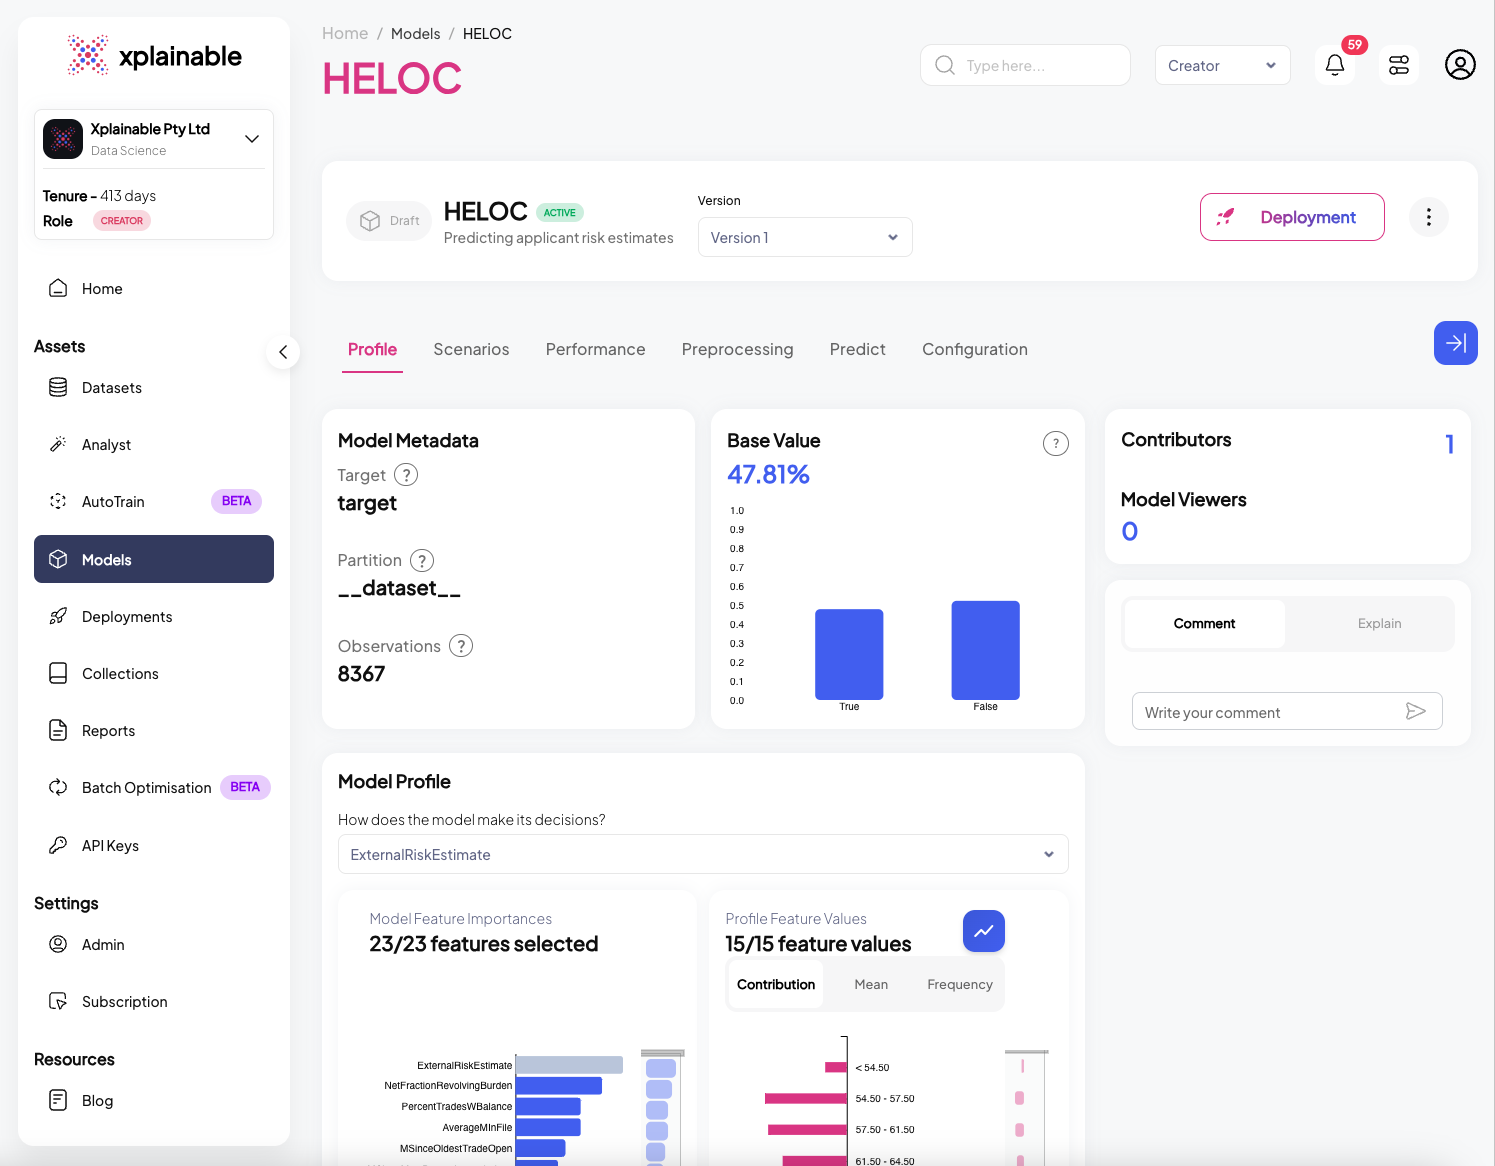

# 6. Deployments

The code block illustrates the deployment of our churn prediction model using the xp.client.deploy function. The deployment process involves specifying the hostname of the server where the model will be hosted, as well as the unique model_id and version_id that we obtained in the previous steps. This step effectively activates the model's endpoint, allowing it to receive and process prediction requests. The output confirms the deployment with a deployment_id, indicating the model's current status as 'inactive', its location, and the endpoint URL where it can be accessed for xplainable deployments.

In [31]:
deployment = client.deploy(
    hostname="https://inference.xplainable.io",
    model_id=model_id,
    version_id=version_id
)

In [32]:
deployment

{'deployment_id': 'Du526MrksjGMu4Np',
 'status': 'inactive',
 'location': 'syd',
 'endpoint': 'https://inference.xplainable.io/v1/predict'}

### Testing the Deployment programatically
This section demonstrates the steps taken to programmatically test a deployed model. These steps are essential for validating that the model's deployment is functional and ready to process incoming prediction requests.

1. **Activating the Deployment:**
   The model deployment is activated using `xp.client.activate_deployment`, which changes the deployment status to active, allowing it to accept prediction requests.

In [33]:
client.activate_deployment(deployment['deployment_id'])

{'message': 'activated deployment'}

2. **Creating a Deployment Key:**
   A deployment key is generated with `xp.client.generate_deploy_key`. This key is required to authenticate and make secure requests to the deployed model.

In [36]:
deploy_key = client.generate_deploy_key('for testing', deployment['deployment_id'], 7)

3. **Generating Example Payload:**
   An example payload for a deployment request is generated by `xp.client.generate_example_deployment_payload`. This payload mimics the input data structure the model expects when making predictions.

In [37]:
#Set the option to highlight multiple ways of creating data
option = 1

In [40]:
if option == 1:
    body = client.generate_example_deployment_payload(deployment['deployment_id'])
else:
    body = json.loads(df.drop(columns=["RiskPerformance"]).sample(1).to_json(orient="records"))
    # body[0]["Gender"] = None #<- Won't require this line the next release of xplainable

In [41]:
body

[{'ExternalRiskEstimate': 66.0,
  'MSinceOldestTradeOpen': 322.0,
  'MSinceMostRecentTradeOpen': None,
  'AverageMInFile': 94.0,
  'NumSatisfactoryTrades': 25.5,
  'NumTrades60Ever2DerogPubRec': 2.5,
  'NumTrades90Ever2DerogPubRec': 1.0,
  'PercentTradesNeverDelq': 98.0,
  'MSinceMostRecentDelq': 27.0,
  'MaxDelq2PublicRecLast12M': -4.5,
  'MaxDelqEver': 3.5,
  'NumTotalTrades': 6.0,
  'NumTradesOpeninLast12M': 2.5,
  'PercentInstallTrades': 5.5,
  'MSinceMostRecentInqexcl7days': -1.5,
  'NumInqLast6M': None,
  'NumInqLast6Mexcl7days': -2.0,
  'NetFractionRevolvingBurden': 20.5,
  'NetFractionInstallBurden': 91.5,
  'NumRevolvingTradesWBalance': 8.5,
  'NumInstallTradesWBalance': None,
  'NumBank2NatlTradesWHighUtilization': None,
  'PercentTradesWBalance': None}]

4. **Making a Prediction Request:**
   A POST request is made to the model's prediction endpoint with the example payload. The model processes the input data and returns a prediction response, which includes the predicted class (e.g., 'No' for no churn) and the prediction probabilities for each class.

In [45]:
deploy_key['deploy_key']

'f2a38982-c4f2-4114-b8ce-d71e37019f5f'

In [43]:
response = requests.post(
    url="https://inference.xplainable.io/v1/predict",
    headers={'api_key': deploy_key['deploy_key']},
    json=body
)

value = response.json()
value

[{'index': 0,
  'id': None,
  'partition': '__dataset__',
  'score': 0.4421742713512326,
  'proba': 0.3200335966035672,
  'pred': 'Bad',
  'support': 918,
  'breakdown': {'base_value': 0.4780686028445082,
   'ExternalRiskEstimate': -0.018834502005451913,
   'MSinceOldestTradeOpen': 0.016605591083751464,
   'MSinceMostRecentTradeOpen': 0.0,
   'AverageMInFile': 0.008550347872215057,
   'NumSatisfactoryTrades': 0.01024150167891105,
   'NumTrades60Ever2DerogPubRec': -0.021627198964509615,
   'NumTrades90Ever2DerogPubRec': -0.014139475517112348,
   'PercentTradesNeverDelq': 0.01801186828646687,
   'MSinceMostRecentDelq': -0.0070614886012018395,
   'MaxDelq2PublicRecLast12M': -0.0025265052623417955,
   'MaxDelqEver': -0.01229060204294862,
   'NumTotalTrades': -0.013329005986282996,
   'NumTradesOpeninLast12M': 0.00315905436830356,
   'PercentInstallTrades': -0.001906562609604855,
   'MSinceMostRecentInqexcl7days': -0.0094064788906335,
   'NumInqLast6M': 0.0,
   'NumInqLast6Mexcl7days': 0.01

## SaaS Deployment Info
The SaaS application interface displayed above mirrors the operations performed programmatically in the earlier steps. It displays a dashboard for managing the 'Telco Customer Churn' model, facilitating a range of actions from deployment to testing, all within a user-friendly web interface. This makes it accessible even to non-technical users who prefer to manage model deployments and monitor performance through a graphical interface rather than code. Features like the deployment checklist, example payload, and prediction response are all integrated into the application, ensuring that users have full control and visibility over the deployment lifecycle and model interactions.

![Heloc Deployment](images/heloc_deployment.png)
